In [1]:
import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

import json

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup
import lxml

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
pip install BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install BeautifulSoup4
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Data scraping from wikipedia

raw_data = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
soup = requests.get(raw_data).text
scraped_data = BeautifulSoup(soup, 'lxml')

In [5]:
# Creating new data frame and transforming the data to df

column_names = ['Postalcode','Borough','Neighborhood']
canada_data = pd.DataFrame(columns = column_names)
canada_data

,Postalcode,Borough,Neighborhood


In [6]:
#Loop the data and updating the data frame one row at a time

content = scraped_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0
table

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
            canada_data = canada_data.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [7]:
canada_data = canada_data[canada_data.Borough!='Not assigned']
canada_data = canada_data[canada_data.Borough!= 0]
canada_data.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,canada_data.shape[0]):
    if canada_data.iloc[i][2] == 'Not assigned':
        canada_data.iloc[i][2] = canada_data.iloc[i][1]
        i = i+1
                                 
df = canada_data.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:

# Data Cleaning

df = df.drop(df[(df.Borough == "Not assigned")].index) # drop rows if the borogh value is not assigned
df.Neighborhood.replace("Not assigned", df.Borough, inplace=True) # if neighborhood is not ssigned ten assign borough
df.Neighborhood.fillna(df.Borough, inplace=True)
df=df.drop_duplicates()

In [9]:
def grp_neighborhood(grouped):
        return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp_attr = df.groupby(['Postalcode', 'Borough'])
df1 = grp_attr.apply(grp_neighborhood).reset_index(name='Neighborhood')

In [10]:
df1.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
# geo data

geo_data = pd.read_csv("http://cocl.us/Geospatial_data")
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
# Merging geo data to the data frame
df_geo_data = df1.join(geo_data.set_index('Postal Code'), on='Postalcode')
df_geo_data

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [37]:
import matplotlib.pyplot as plt

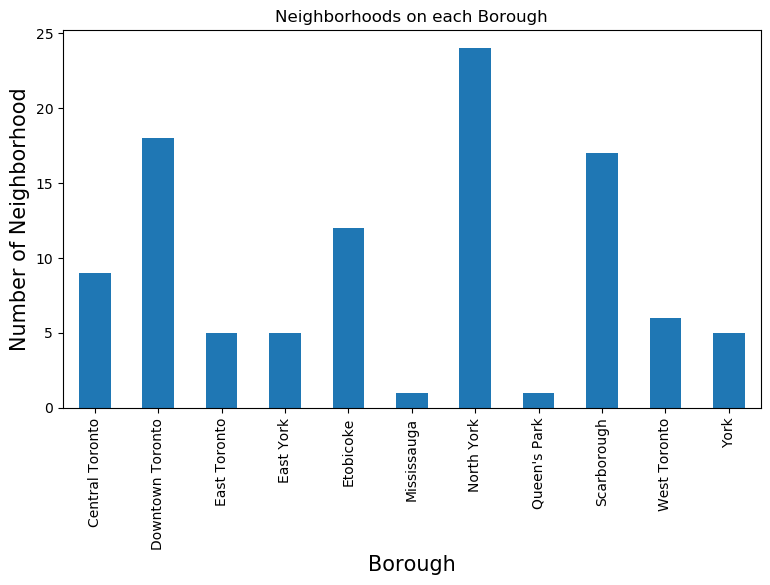

In [41]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Neighborhoods on each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Neighborhood', fontsize=15)
df_geo_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.show()

# North York has higher number of neighborhoods

In [104]:
#Finding coordinates of Toronto

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of toronto are 43.653963, -79.387207.


In [15]:
# Creating map of toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df_geo_data['Latitude'], df_geo_data['Longitude'], df_geo_data['Borough'], df_geo_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [18]:
# Foursquare Credentials and Version

CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'Your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VCE3BFI5H3LYTHSZKAY1WEEBUGJCDTIFTAXVJHFDZVEBNW0D
CLIENT_SECRET:FYIMB3PO5KR3JJQ4O1ZQRJPAZNWZAZCWUL4U3FZDWU5LXPYF


In [102]:
# As North yourk has the highest noumber of neighborhood, slicing the North York  data and creating a new data frame

North_York_data = df_geo_data[df_geo_data['Borough'] == 'North York'].reset_index(drop=True)
North_York_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M2H,North York,Hillcrest Village,43.803762,-79.363452
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
2,M2K,North York,Bayview Village,43.786947,-79.385975
3,M2L,North York,"Silver Hills, York Mills",43.757490,-79.374714
4,M2M,North York,"Newtonbrook, Willowdale",43.789053,-79.408493


In [103]:
Borough_data = df_geo_data
Borough_data.shape

(103, 5)

In [46]:
North_York_data.shape

(24, 5)

In [47]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York are 43.7708175, -79.4132998.


In [105]:
# Neighborhoods of toronto
Borough_data.loc[0,'Neighborhood']
Borough_data.loc[1,'Neighborhood']
Borough_data.loc[2,'Neighborhood']

'Guildwood, Morningside, West Hill'

In [92]:
# identifying neighborhood latitude and longitude

neighborhood_latitude = df_geo_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_geo_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_geo_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.806686299999996, -79.19435340000001.


In [93]:
LIMIT = 500 # no of venues

radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VCE3BFI5H3LYTHSZKAY1WEEBUGJCDTIFTAXVJHFDZVEBNW0D&client_secret=FYIMB3PO5KR3JJQ4O1ZQRJPAZNWZAZCWUL4U3FZDWU5LXPYF&v=20180605&ll=43.7708175,-79.4132998&radius=1000&limit=500'

In [ ]:
#Examining the results of GET request

results = requests.get(url).json()
results

In [55]:
# function that extracts the category of the venue


def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [95]:
# structuring the venues into a data frame

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Captain's Boil,Seafood Restaurant,43.773255,-79.413805
1,Konjiki Ramen,Ramen Restaurant,43.766998,-79.412222
2,Aroma Espresso Bar,Café,43.769449,-79.413081
3,The Keg,Steakhouse,43.766579,-79.412131
4,Starbucks,Coffee Shop,43.768353,-79.413046


In [89]:
nearby_venues.shape

(100, 5)

In [58]:
nearby_venues

,name,categories,lat,lng
0,The Captain's Boil,Seafood Restaurant,43.773255,-79.413805
1,Konjiki Ramen,Ramen Restaurant,43.766998,-79.412222
2,Aroma Espresso Bar,Café,43.769449,-79.413081
3,The Keg,Steakhouse,43.766579,-79.412131
4,Starbucks,Coffee Shop,43.768353,-79.413046
5,Loblaws,Grocery Store,43.768722,-79.412101
6,Cineplex Cinemas Empress Walk,Movie Theater,43.768625,-79.412613
7,Pastel Creperie & Dessert House,Creperie,43.776219,-79.414648
8,Toronto Centre for the Arts,Theater,43.766228,-79.414115
9,Burrito Boyz,Burrito Place,43.773054,-79.414082


In [61]:
nearby_venues_Gym = nearby_venues[nearby_venues['categories'] == 'Gym'].reset_index(drop=True)
nearby_venues_Gym.head()

,name,categories,lat,lng
0,GoodLife Fitness North York Madison Centre,Gym,43.764836,-79.412709


In [65]:

# all the near by central toronto venues

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)       
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)           
        
        results = requests.get(url).json()["response"]['groups'][0]['items']       
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues_Gym = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues_Gym.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    return(nearby_venues_Gym)

In [81]:
North_York_Venues = getNearbyVenues(names=North_York_data['Neighborhood'],
                                   latitudes=North_York_data['Latitude'],
                                   longitudes=North_York_data['Longitude']
                                  )

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Bedford Park, Lawrence Manor East
Lawrence Heights, Lawrence Manor
Glencairn
Downsview, North Park, Upwood Park
Humber Summit
Emery, Humberlea


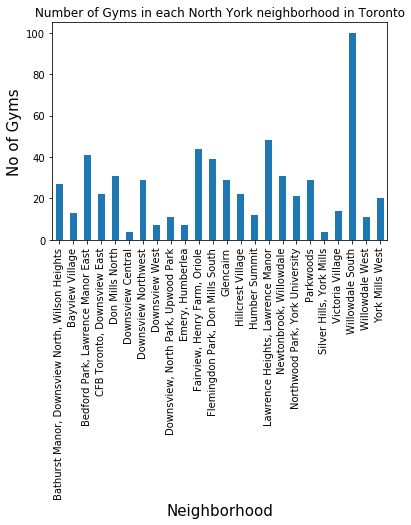

In [116]:
plt.title('Number of Gyms in each North York neighborhood in Toronto')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No of Gyms', fontsize=15)
North_York_Venues.groupby('Neighborhood')['Venue Category'].count().plot(kind='bar')
plt.show()

In [115]:
North_York_Venues.shape

(616, 7)

In [117]:
print('There are {} uniques categories.'.format(len(North_York_Venues['Neighborhood'].unique())))

There are 24 uniques categories.


In [83]:
North_York_Venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hillcrest Village,43.803762,-79.363452,Tastee,43.807722,-79.356798,Bakery
1,Hillcrest Village,43.803762,-79.363452,고려삼계탕 Korean Ginseng Chicken Soup & Bibimbap,43.798391,-79.369187,Korean Restaurant
2,Hillcrest Village,43.803762,-79.363452,Galati,43.797831,-79.369410,Grocery Store
3,Hillcrest Village,43.803762,-79.363452,Cummer Park,43.799564,-79.371175,Park
4,Hillcrest Village,43.803762,-79.363452,Tim Hortons,43.798945,-79.369644,Coffee Shop
5,Hillcrest Village,43.803762,-79.363452,Pizza Pizza,43.799079,-79.369449,Pizza Place
6,Hillcrest Village,43.803762,-79.363452,TD Canada Trust,43.798466,-79.368832,Bank
7,Hillcrest Village,43.803762,-79.363452,Subway,43.799047,-79.369438,Sandwich Place
8,Hillcrest Village,43.803762,-79.363452,New York Fries,43.803664,-79.363905,Fast Food Restaurant
9,Hillcrest Village,43.803762,-79.363452,Shoppers Drug Mart,43.798341,-79.369804,Pharmacy


In [86]:
#Slicing north york data frame - gym
North_York_Venues_Gym = North_York_Venues[North_York_Venues['Venue Category'] == 'Gym'].reset_index(drop=True)
North_York_Venues_Gym.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Willowdale South,43.770120,-79.408493,GoodLife Fitness North York Madison Centre,43.764836,-79.412709,Gym
1,"Flemingdon Park, Don Mills South",43.725900,-79.340923,Fitness Connection,43.727473,-79.341707,Gym
2,"Flemingdon Park, Don Mills South",43.725900,-79.340923,GoodLife Fitness North York Don Mills and Egli...,43.722704,-79.337508,Gym
3,"Flemingdon Park, Don Mills South",43.725900,-79.340923,Dallimore Cir Gym,43.730706,-79.332316,Gym
4,"CFB Toronto, Downsview East",43.737473,-79.464763,Sporttesting,43.744320,-79.457542,Gym


In [118]:
#Slicing north york data frame - Recreation center
North_York_Venues_RC = North_York_Venues[North_York_Venues['Venue Category'] == 'Recreation Center'].reset_index(drop=True)
North_York_Venues_RC.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hillcrest Village,43.803762,-79.363452,Cummer Park Community Centre,43.800109,-79.370981,Recreation Center


In [121]:
#Slicing north york data frame - Residential Building
North_York_Venues_RB = North_York_Venues[North_York_Venues['Venue Category'] == 'Residential Building (Apartment / Condo)'].reset_index(drop=True)
North_York_Venues_RB.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hillcrest Village,43.803762,-79.363452,Woodbrooke Estate,43.802067,-79.354347,Residential Building (Apartment / Condo)


In [122]:
North_York_Venues_RB.shape

(1, 7)

In [87]:
North_York_Venues_Gym.shape

(8, 7)

In [119]:
North_York_Venues_RC.shape

(1, 7)

In [71]:
North_York_Venues_Gym

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Willowdale South,43.770120,-79.408493,GoodLife Fitness North York Madison Centre,43.764836,-79.412709,Gym
1,"Flemingdon Park, Don Mills South",43.725900,-79.340923,Fitness Connection,43.727473,-79.341707,Gym
2,"Flemingdon Park, Don Mills South",43.725900,-79.340923,GoodLife Fitness North York Don Mills and Egli...,43.722704,-79.337508,Gym
3,"Flemingdon Park, Don Mills South",43.725900,-79.340923,Dallimore Cir Gym,43.730706,-79.332316,Gym
4,"CFB Toronto, Downsview East",43.737473,-79.464763,Sporttesting,43.744320,-79.457542,Gym
5,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,Columbus Centre,43.713012,-79.456487,Gym
6,Glencairn,43.709577,-79.445073,Columbus Centre,43.713012,-79.456487,Gym
7,Glencairn,43.709577,-79.445073,Fit4less,43.716687,-79.447473,Gym


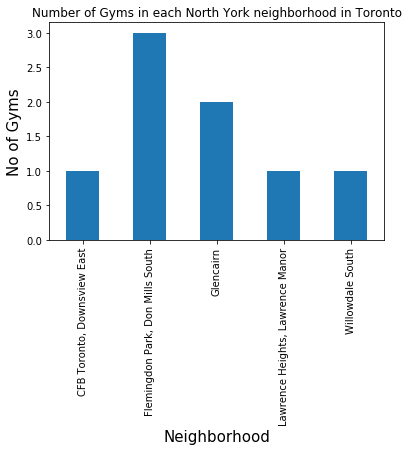

In [72]:
plt.title('Number of Gyms in each North York neighborhood in Toronto')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No of Gyms', fontsize=15)
North_York_Venues_Gym.groupby('Neighborhood')['Venue Category'].count().plot(kind='bar')
plt.show()

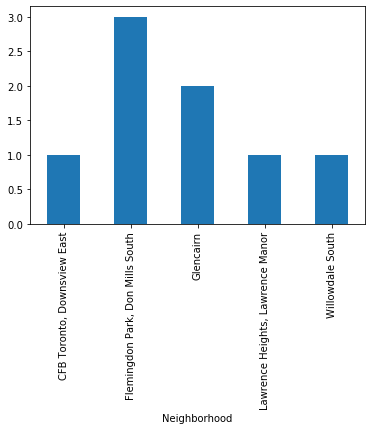

In [106]:
North_York_Venues_Gym.groupby('Neighborhood').count()

In [76]:
# one hot encoding
North_york_onehot = pd.get_dummies(North_York_Venues_Gym[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
North_york_onehot['Neighborhood'] = North_York_Venues_Gym['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [North_york_onehot.columns[-1]] + list(North_york_onehot.columns[:-1])
North_york_onehot = North_york_onehot[fixed_columns]

North_york_onehot

,Neighborhood,Gym
0,Willowdale South,1
1,"Flemingdon Park, Don Mills South",1
2,"Flemingdon Park, Don Mills South",1
3,"Flemingdon Park, Don Mills South",1
4,"CFB Toronto, Downsview East",1
5,"Lawrence Heights, Lawrence Manor",1
6,Glencairn,1
7,Glencairn,1


In [78]:
# grouping neighborhood by taking mean of the frequency of occurence of each category

North_york_onehot = North_york_onehot.groupby('Neighborhood').mean().reset_index()
North_york_onehot

,Neighborhood,Gym
0,"CFB Toronto, Downsview East",1
1,"Flemingdon Park, Don Mills South",1
2,Glencairn,1
3,"Lawrence Heights, Lawrence Manor",1
4,Willowdale South,1


•	There are total 24 neighborhoods in  North York , but only 8 gym’s are available in across 8 neighborhood.
•	Hill crest village does not have a gym, 1 recreation center is available and also this neighborhood includes a residential building. Most of the residential building is equipped with physical center.
•	There is large scope for physical center in North York borough.
